In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn

import h5py

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [ ]:
imgs_path = '/content/drive/My Drive/Mask RCNN dataset/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/content/drive/My Drive/Mask RCNN dataset/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '/content/drive/My Drive/Mask RCNN dataset/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '/content/drive/My Drive/Mask RCNN dataset/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]

### **LOADING DATASET**

In [ ]:
import numpy as np

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        # TODO: load dataset, make mask list
      h5images = h5py.File(path[0],'r')
      h5masks = h5py.File(path[1],'r')
      self.images = h5images.get(f'{list(h5images.keys())[0]}')
      self.oldmasks = h5masks.get(f'{list(h5masks.keys())[0]}')
      self.labels = np.load(path[2], allow_pickle=True)
      self.bboxes = np.load(path[3], allow_pickle=True)
      j = 0
      m=[]
      for i in range(len(self.labels)):
        m.append(self.oldmasks[j:j+len(self.labels[i])])
        j = j + len(self.labels[i])
      self.masks=np.array(m)
      

    def __len__(self):
        return len(self.images)


    def __getitem__(self, index):

      transform = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
      img = torch.tensor(self.images[index].astype(float)).unsqueeze(0)
      img=img/255
      imgnew = transform(F.interpolate(img, size=(800, 1066), mode='nearest').squeeze(0))
      imgnew = F.pad(imgnew, (11,11), 'constant', 0) 
      label = torch.tensor(self.labels[index]) 

      masknew = torch.tensor(self.masks[index].astype(float)).unsqueeze(0)
      masknew = F.interpolate(masknew, size=(800, 1066), mode='nearest').squeeze(0)
      masknew = F.pad(masknew, (11,11), 'constant', 0)

      bbox1 = np.copy(self.bboxes[index])
      bbox1[:, 0] = bbox1[:, 0] * (800/300)
      bbox1[:, 1] = bbox1[:, 1] * (1066/400) + 11
      bbox1[:, 2] = bbox1[:, 2] * (800/300)        
      bbox1[:, 3] = bbox1[:, 3] *(1066/400) + 11        
      bbox1 = torch.tensor(bbox1).squeeze(0)

      return imgnew, label, masknew, bbox1,index

In [ ]:
class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    def collect_fn(self, batch):

        transed_img_list = []
        label_list = []
        

        transed_mask_list = []
        transed_bbox_list = []
        index_list=[]
        for transed_img, label, transed_mask, transed_bbox,index in batch:
            transed_img_list.append(transed_img.unsqueeze(0))
            label_list.append(label)
            transed_mask_list.append(transed_mask)
            transed_bbox_list.append(transed_bbox)
            index_list.append(index)


        return transed_img_list, label_list, transed_mask_list, transed_bbox_list,index_list


    def loader(self):
        return DataLoader(dataset=self.dataset,
                      batch_size=self.batch_size,
                      shuffle=self.shuffle,
                      collate_fn=self.collect_fn, 
                      num_workers = self.num_workers,drop_last=True)

In [ ]:
# load the data into data.Dataset
Dataset = BuildDataset(paths)
batch_size = 1
build_loader = BuildDataLoader(Dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader = build_loader.loader()

print(len(dataloader))

3265


###  VISUAL CORRECTNESS

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[tensor([3])]
[tensor([133.7833, 283.2297, 472.3333, 677.1334])]


<Figure size 432x288 with 0 Axes>

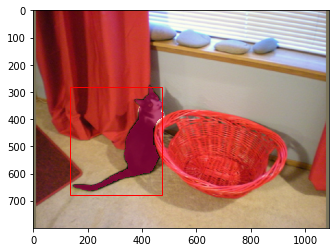

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[tensor([2])]
[tensor([232.0000, 182.1430, 384.4500, 382.7175])]


<Figure size 432x288 with 0 Axes>

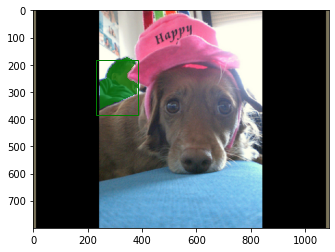

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[tensor([1])]
[tensor([153.9167, 111.3372, 966.4501, 658.6450])]


<Figure size 432x288 with 0 Axes>

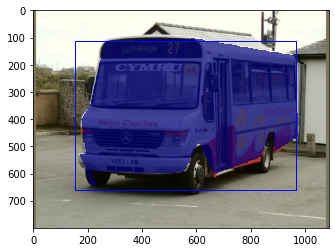

In [ ]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from PIL import Image
k=0
mask_color_list = ["jet", "ocean","Spectral"]
bbox_color=['b','g','r']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for iter, data in enumerate(dataloader, 0):

    img, label, mask, bbox,index = [data[i] for i in range(len(data))]

    plt.figure()
    for i in range(batch_size):

      fig,ax = plt.subplots(1)
      opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
      img_plot = opp_transform(img[i].squeeze(0))
      img_plot=img_plot*255.0
      plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))
      if (len(mask[i])>1):
        m1=mask[i][0]
        m2=mask[i][1]
        m1 = np.reshape(m1,(800,1088,1))
        maskedm1 = np.ma.masked_where(m1 == 0, m1)
        maskedm1=np.squeeze(maskedm1)
        plt.imshow(maskedm1, cmap=mask_color_list[label[i][0].item()-1], alpha=0.7)
        m2 = np.reshape(m2,(800,1088,1))
        maskedm2 = np.ma.masked_where(m2 == 0, m2)
        maskedm2=np.squeeze(maskedm2)
        plt.imshow(maskedm2, cmap=mask_color_list[label[i][1].item()-1], alpha=0.7)
        rect1 = patches.Rectangle((bbox[i][0][0],bbox[i][0][1]),(bbox[i][0][2]-bbox[i][0][0]),(bbox[i][0][3]-bbox[i][0][1]),linewidth=1,edgecolor=bbox_color[label[i][0].item()-1],facecolor='none')
        ax.add_patch(rect1)
        rect1 = patches.Rectangle((bbox[i][1][0],bbox[i][1][1]),(bbox[i][1][2]-bbox[i][1][0]),(bbox[i][1][3]-bbox[i][1][1]),linewidth=1,edgecolor=bbox_color[label[i][1].item()-1],facecolor='none')
        ax.add_patch(rect1)
      else: 
        mask[i] = np.reshape(mask[i],(800,1088,len(mask[i])))
        masked = np.ma.masked_where(mask[i] == 0, mask[i])
        masked=np.squeeze(masked)
        plt.imshow(masked, cmap=mask_color_list[label[i].item()-1], alpha=0.7)
        rect1 = patches.Rectangle((bbox[i][0],bbox[i][1]),(bbox[i][2]-bbox[i][0]),(bbox[i][3]-bbox[i][1]),linewidth=1,edgecolor=bbox_color[label[i].item()-1],facecolor='none')
        ax.add_patch(rect1) 
      k=k+1
      print(label)
      print(bbox)
      plt.show()

    if iter == 2:
      break
  

### PRETRAINED BACKBONE AND RPN

In [ ]:
import torchvision
import torch

def pretrained_models_680(checkpoint_file,eval=True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    if(eval):
        model.eval()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    backbone = model.backbone
    rpn = model.rpn
    if(eval):
        backbone.eval()
        rpn.eval()
    rpn.nms_thresh=0.6
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    return backbone, rpn

In [ ]:
# Put the path were you save the given pretrained model
pretrained_path='/content/drive/My Drive/FasterRCNN/checkpoint680.pth'
device = torch.device("cuda")
backbone, rpn = pretrained_models_680(pretrained_path)
backbone=backbone.to(device)

rpn=rpn.to(device)
from torchvision.models.detection.image_list import ImageList

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
dataset = BuildDataset(paths)
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(90)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# push the randomized training data into the dataloader

train_batch_size = 4
test_batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()


For the proposals We have a list containing 1 tensors
Each one with shape torch.Size([5, 4])


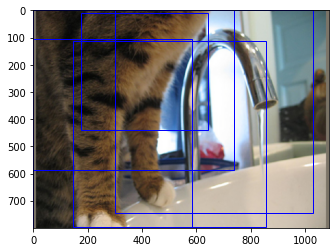

In [ ]:

for iter,data in enumerate(test_loader):
  img,label,_,_,index = [data[i] for i in range(len(data))]
  index = torch.tensor(index).view(-1)
  img_batch = [i for i in img]
  img_batch = torch.cat(img_batch)
  img_batch = img_batch.float().to(device)
  backout = backbone(img_batch)
  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(img_batch, [(800, 1088)]*img_batch.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)
  #The final output is
  # A list of proposal tensors: list:len(bz){(keep_topK,4)}
  proposals=[proposal[0:5,:] for proposal in rpnout[0]]
  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list= list(backout.values())

  print("For the proposals We have a list containing "+str(len(proposals))+" tensors")
  print("Each one with shape "+str(proposals[0].shape))


  # Visualization of the proposals
  for i in range(batch_size):
      e=0    
      img_squeeze = transforms.functional.normalize(img_batch[i,:,:,:].to('cpu'),
                                                    [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                    [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
      fig,ax=plt.subplots(1,1)
      ax.imshow(img_squeeze.permute(1,2,0))
      for box in proposals[i]:
        box=box.view(-1)
        # print(box)
        rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b')
        ax.add_patch(rect)
      plt.show()
  if e==0:
    break

##FPN Shapes

In [ ]:
print(backout['0'].shape)
print(backout['1'].shape)
print(backout['2'].shape)
print(backout['3'].shape)

torch.Size([10, 256, 200, 272])
torch.Size([10, 256, 100, 136])
torch.Size([10, 256, 50, 68])
torch.Size([10, 256, 25, 34])


### PREPARATION OF RPN OUTPUTS FOR THE SECOND STAGE

In [ ]:
def IOU(bbox_1 ,bbox_2):
  x_1up=bbox_1[0]
  y_1up=bbox_1[1]
  x_1l=bbox_1[2]
  y_1l=bbox_1[3]

  x_2up=bbox_2[0]
  y_2up=bbox_2[1]
  x_2l=bbox_2[2]
  y_2l=bbox_2[3]


 
  x_up=max(x_1up,x_2up)
  y_up=max(y_1up,y_2up)
  x_l=min(x_1l,x_2l)
  y_l=min(y_1l,y_2l)
  

  inter_area=max((x_l-x_up+1),0)*max((y_l-y_up+1),0)
  area_box1=(x_1l-x_1up+1)*(y_1l-y_1up+1)
  area_box2=(x_2l-x_2up+1)*(y_2l-y_2up+1)
  
  union_area=area_box1+area_box2-inter_area
  iou=inter_area/float(union_area)
  return iou

In [ ]:
all_proposals=torch.zeros((len(dataloader),200,4))
proposal_class=torch.zeros((len(dataloader),200))
proposal_gt_bboxes=torch.zeros((len(dataloader),200,4))
proposal_gt_bboxes_p=torch.zeros((len(dataloader),200,4))
# stride=[4,8,16,32]
# proposal_roialign={}

for iter,data in enumerate(dataloader):
  img,label,_,bbox,index = [data[i] for i in range(len(data))]
  index = torch.tensor(index).view(-1)
  img_batch = [i.unsqueeze(0) for i in img]
  img_batch = torch.cat(img_batch)
  
  img_batch = img_batch.squeeze(1).float().to(device)
  backout = backbone(img_batch)

  im_lis = ImageList(img_batch, [(800, 1088)])

  rpnout = rpn(im_lis, backout)

  proposals=[proposal[0:200,:] for proposal in rpnout[0]]

  fpn_feat_list= list(backout.values())
  proposals[0]=proposals[0].cpu()
  bound_box=bbox[0].cpu()
  label[0]=label[0].cpu().numpy()
  classes=np.zeros(200)
  gt_bboxes=np.zeros((200,4))
  gt_bboxes_p=np.zeros((200,4))

  if len(bound_box)==2:
    for i in range(len(proposals[0])):
   
      c = IOU(proposals[0][i],bound_box[0])
      d = IOU(proposals[0][i],bound_box[1])
      if c > 0.5 and d >0.5:
        if c>d:
          classes[i]=label[0][0]  
          gt_bboxes[i]=bound_box[0]

          x_star=(bound_box[0][0]+bound_box[0][2])/2
          y_star=(bound_box[0][1]+bound_box[0][3])/2
          w_star=bound_box[0][2]-bound_box[0][0]
          h_star=bound_box[0][3]-bound_box[0][1]
          x_a=(proposals[0][i][0]+proposals[0][i][2])/2
          y_a=(proposals[0][i][1]+proposals[0][i][3])/2
          w_a=proposals[0][i][2]-proposals[0][i][0]
          h_a=proposals[0][i][3]-proposals[0][i][1]

          gt_bboxes_p[i][0]=(x_star-x_a)/w_a
          gt_bboxes_p[i][1]=(y_star-y_a)/h_a
          gt_bboxes_p[i][2]=np.log(w_star/w_a)
          gt_bboxes_p[i][3]=np.log(h_star/h_a)
          print(classes[i])
        elif c<d:
          classes[i]=label[0][1]  
          gt_bboxes[i]=bound_box[1]
  
          x_star=(bound_box[1][0]+bound_box[1][2])/2
          y_star=(bound_box[1][1]+bound_box[1][3])/2
          w_star=bound_box[1][2]-bound_box[1][0]
          h_star=bound_box[1][3]-bound_box[1][1]
          x_a=(proposals[0][i][0]+proposals[0][i][2])/2
          y_a=(proposals[0][i][1]+proposals[0][i][3])/2
          w_a=proposals[0][i][2]-proposals[0][i][0]
          h_a=proposals[0][i][3]-proposals[0][i][1]

          gt_bboxes_p[i][0]=(x_star-x_a)/w_a
          gt_bboxes_p[i][1]=(y_star-y_a)/h_a
          gt_bboxes_p[i][2]=np.log(w_star/w_a)
          gt_bboxes_p[i][3]=np.log(h_star/h_a)
          print(classes[i])
      elif c>0.5:
        classes[i]=label[0][0]
        gt_bboxes[i]=bound_box[0]
        
        x_star=(bound_box[0][0]+bound_box[0][2])/2
        y_star=(bound_box[0][1]+bound_box[0][3])/2
        w_star=bound_box[0][2]-bound_box[0][0]
        h_star=bound_box[0][3]-bound_box[0][1]
        x_a=(proposals[0][i][0]+proposals[0][i][2])/2
        y_a=(proposals[0][i][1]+proposals[0][i][3])/2
        w_a=proposals[0][i][2]-proposals[0][i][0]
        h_a=proposals[0][i][3]-proposals[0][i][1]

        gt_bboxes_p[i][0]=(x_star-x_a)/w_a
        gt_bboxes_p[i][1]=(y_star-y_a)/h_a
        gt_bboxes_p[i][2]=np.log(w_star/w_a)
        gt_bboxes_p[i][3]=np.log(h_star/h_a)
      elif d>0.5:
        classes[i]=label[0][1]  
        gt_bboxes[i]=bound_box[1]

        x_star=(bound_box[1][0]+bound_box[1][2])/2
        y_star=(bound_box[1][1]+bound_box[1][3])/2
        w_star=bound_box[1][2]-bound_box[1][0]
        h_star=bound_box[1][3]-bound_box[1][1]
        x_a=(proposals[0][i][0]+proposals[0][i][2])/2
        y_a=(proposals[0][i][1]+proposals[0][i][3])/2
        w_a=proposals[0][i][2]-proposals[0][i][0]
        h_a=proposals[0][i][3]-proposals[0][i][1]

        gt_bboxes_p[i][0]=(x_star-x_a)/w_a
        gt_bboxes_p[i][1]=(y_star-y_a)/h_a
        gt_bboxes_p[i][2]=np.log(w_star/w_a)
        gt_bboxes_p[i][3]=np.log(h_star/h_a)
      else:
        classes[i]=0    

  else:
    for i in range(len(proposals[0])):
      if IOU(proposals[0][i],bound_box) > 0.5:
        classes[i]=label[0]  
        gt_bboxes[i]=bound_box
        x_star=(bound_box[0]+bound_box[2])/2
        y_star=(bound_box[1]+bound_box[3])/2
        w_star=bound_box[2]-bound_box[0]
        h_star=bound_box[3]-bound_box[1]
        x_a=(proposals[0][i][0]+proposals[0][i][2])/2
        y_a=(proposals[0][i][1]+proposals[0][i][3])/2
        w_a=proposals[0][i][2]-proposals[0][i][0]
        h_a=proposals[0][i][3]-proposals[0][i][1]

        gt_bboxes_p[i][0]=(x_star-x_a)/w_a
        gt_bboxes_p[i][1]=(y_star-y_a)/h_a
        gt_bboxes_p[i][2]=np.log(w_star/w_a)
        gt_bboxes_p[i][3]=np.log(h_star/h_a)              
      else:
        classes[i]=0

  proposal_class[index[0]]=torch.tensor(classes)
  all_proposals[index[0]]=torch.tensor(proposals[0])
  proposal_gt_bboxes[index[0]]=torch.tensor(gt_bboxes)
  proposal_gt_bboxes_p[index[0]]=torch.tensor(gt_bboxes_p)

  print(iter)

##Saving ground truth values

##Loading saved ground truth values

In [ ]:
proposal_class=np.load("/content/drive/My Drive/proposal_class.npy")
proposal_gt_bboxes=np.load('/content/drive/My Drive/proposal_gt_bboxes.npy')
all_proposals=np.load('/content/drive/My Drive/all_proposals.npy')
proposal_gt_bboxes_p=np.load('/content/drive/My Drive/proposal_gt_bboxes_p.npy')

### 6.1 Visualization of the proposals with the no-background classes and their ground truth boxes.

[tensor([3])]


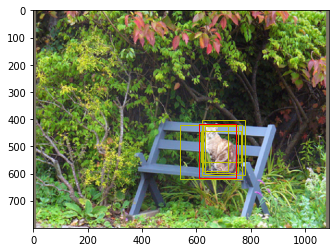

In [ ]:
e=0
for iter,data in enumerate(dataloader):
  img,label,_,bbox,index = [data[i] for i in range(len(data))]
  print(label)
  index = torch.tensor(index).view(-1)
  img_batch = [i.unsqueeze(0) for i in img]
  img_batch = torch.cat(img_batch)
  img_batch = img_batch.squeeze(1).float().to(device)
  backout = backbone(img_batch)
  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(img_batch, [(800, 1088)])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)
  #The final output is
  # A list of proposal tensors: list:len(bz){(keep_topK,4)}
  proposals=[proposal[0:200,:] for proposal in rpnout[0]]
  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list= list(backout.values())
  proposals[0]=proposals[0].cpu()
  if e==0:
    break
bbox_color=['b','g','r']
for j in range(1):   
      img_squeeze = transforms.functional.normalize(img_batch[j,:,:,:].to('cpu'),
                                                    [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                    [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
      fig,ax=plt.subplots(1,1)
      ax.imshow(img_squeeze.permute(1,2,0))
      for i in range(200):
        box=proposals[0][i]
        # print(box)
        if (proposal_class[index[0]][i]!=0):
          rect=patches.Rectangle((box[0],box[1
                                             ]),box[2]-box[0],box[3]-box[1],fill=False,color='y')
          ax.add_patch(rect)
          rect=patches.Rectangle((proposal_gt_bboxes[
                                                     index[0].item()][i][0],proposal_gt_bboxes[index[0].item()][i][1]),proposal_gt_bboxes[index[0].item()][i][2]-proposal_gt_bboxes[index[0].item()][i][0],proposal_gt_bboxes[index[0].item()][i][3]-proposal_gt_bboxes[index[0].item()][i][1],linewidth=1,edgecolor=bbox_color[int(proposal_class[index[0].item()][i].item()-1)],facecolor='none')
          ax.add_patch(rect)
      plt.show()

##ROI Align

In [ ]:
import torchvision

In [ ]:
def ROIAlign(fpn_feat_list,proposals,p=7):
  K = []
  feat_vectors = [torch.zeros(200,256*49).to(device) for _ in range(len(proposals))]
  ## assigning each bounding box of an image to different fpn_levels
  for i,proposal in enumerate(proposals):
    w = proposal[:,2] - proposal[:,0]
    h = proposal[:,3] - proposal[:,1]
    k = torch.floor(4+torch.log2(torch.sqrt(w*h)/224))
    less2ind = (k<=2).nonzero()
    more5ind = (k>=5).nonzero()
    k[less2ind] = 2
    k[more5ind] = 5
    k -= 2
    K.append(k)
   
  
  stride_factor = [4,8,16,32]
  ## ROI Align
  for i in range(len(fpn_feat_list)-1):
    k_ind = [(K[it]==i).nonzero().view(-1) for it in range(len(proposals))]
    bboxes = [proposal[k_ind[it]].squeeze(1)/stride_factor[i] for it,proposal in enumerate(proposals)]
    roi_out = torchvision.ops.roi_align(fpn_feat_list[i],bboxes,output_size=7)
    roi_out = roi_out.view(-1,256*49)
    for it in range(len(proposals)):
      feat_vectors[it][k_ind[it]] = roi_out[:k_ind[it].shape[0]]
      roi_out = roi_out[k_ind[it].shape[0]:]
    
      
  return feat_vectors

##Box Head Network

In [ ]:
import torch.nn as nn
class BoxHead(nn.Module):
  def __init__(self):
    super(BoxHead,self).__init__()
    self.Intermediate = nn.Sequential(nn.Linear(256*49,1024),nn.ReLU(),nn.Linear(1024,1024),nn.ReLU())
    self.Classifier = nn.Linear(1024,4)
    self.Regressor = nn.Linear(1024,12) 

  def forward(self,x):
    x = self.Intermediate(x)
    class_out = self.Classifier(x)
    reg_out = self.Regressor(x)
    return class_out,reg_out


### LOSS 

In [ ]:
def Loss(out_class,out_bbox,target_class,target_bbox):
  ##Subsample size 
  M = 64
  target_class_flatten = target_class.view(-1)
  out_class_flatten = out_class.view(-1)
  
  ##Subsampling calculation
  pos_indices = (target_class_flatten != 0).nonzero()
  neg_indices = (target_class_flatten == 0).nonzero()
  pos_indices = pos_indices[torch.randperm(pos_indices.size()[0])]
  neg_indices = neg_indices[torch.randperm(neg_indices.size()[0])]

  chosen_pos_ind = 0
  chosen_neg_ind = 0
  if pos_indices.size()[0] > int(M*0.75):
    chosen_pos_ind = pos_indices[:int(M*0.75)]
    chosen_neg_ind = neg_indices[:M-int(M*0.75)]
  else:
    chosen_pos_ind = pos_indices
    chosen_neg_ind = neg_indices[:M-pos_indices.size()[0]]
  indices = torch.cat((chosen_pos_ind,chosen_neg_ind),0)
  subsample_target_obj = target_class_flatten[indices]

  subsample_out_obj = out_class[indices]
  subsample_target_bbox = target_bbox[chosen_pos_ind].squeeze(1)
  subsample_out_bbox = out_bbox[chosen_pos_ind].squeeze(1)

  ##Classifier Loss
  class_loss = nn.CrossEntropyLoss()

  classifier_loss = class_loss(subsample_out_obj.squeeze(1).float(),subsample_target_obj.view(-1).long())

  reg_loss = nn.SmoothL1Loss()

  k=target_class_flatten[chosen_pos_ind]
  new_subsample=torch.zeros(len(subsample_target_bbox),4).to(device)

  for i in range(len(k)):

    new_subsample[i][:]=subsample_out_bbox[i][4*int(k[i])-4:4*int(k[i])]
  regressor_loss = reg_loss(new_subsample,subsample_target_bbox)*(chosen_pos_ind.size()[0]*4/M)

  return classifier_loss,regressor_loss,classifier_loss+5*regressor_loss


## Training Loop

##Loading saved ground truth proposals

In [ ]:
proposal_class=torch.tensor(np.load("/content/drive/My Drive/proposal_class.npy")).long()
proposal_gt_bboxes=torch.tensor(np.load('/content/drive/My Drive/proposal_gt_bboxes.npy'))
all_proposals=torch.tensor(np.load('/content/drive/My Drive/all_proposals.npy'))
proposal_gt_bboxes_p=torch.tensor(np.load('/content/drive/My Drive/proposal_gt_bboxes_p.npy'))

TRAINING

In [ ]:
import time
import os
trainloss=[]
epoch_count=[]
classifierloss=[]
regressorloss=[]
trainloss=[]
idx=[]
classifierloss=[]
regressorloss=[]
resume = False
learning_rate = 0.001
boxhead = BoxHead()
boxhead = boxhead.to(device)
optimizer=torch.optim.Adam(boxhead.parameters(),lr=learning_rate,weight_decay=0.0001)

path = '/content/drive/MyDrive/FasterRCNN/Models'
if resume == True:
  checkpoint = torch.load(path)
  rpn.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochs = checkpoint['epoch']

num_epochs = 40
cnt = 0
tot_loss_100 = 0
cls_loss_100 = 0
reg_loss_100 = 0
boxhead.train()
for epochs in range(num_epochs):
  correct=0
  overall_tloss = 0
  overall_closs=0
  overall_rloss=0
  total = 0
  start = time.time()
  for iter,data in enumerate(train_loader):
    optimizer.zero_grad()
    img,_,_,_,index = [data[i] for i in range(len(data))]
    index = torch.tensor(index).view(-1)
    target_class = proposal_class[index].view(-1,1).to(device)
    target_bbox = proposal_gt_bboxes_p[index].view(-1,4).to(device)
    img = torch.cat(img).float().to(device)
    backout = backbone(img)
    fpn_feat_list = list(backout.values())
    im_lis = ImageList(img,[(800,1088)]*img.shape[0])
    rpnout = rpn(im_lis,backout)
    proposals = [proposal[:200,:] for proposal in rpnout[0]]
    feat_vectors = ROIAlign(fpn_feat_list,proposals)
    feat_vectors = torch.cat(feat_vectors)
    class_out,reg_out = boxhead(feat_vectors)
    print(class_out.shape,reg_out.shape)
    class_loss,reg_loss,tot_loss = Loss(class_out,reg_out,target_class,target_bbox)
    overall_tloss+=tot_loss.item()
    overall_closs+=class_loss.item()
    overall_rloss+=reg_loss.item()
    cls_loss_100 += class_loss.item()
    reg_loss_100 += reg_loss.item()
    tot_loss_100 += tot_loss.item()
    tot_loss.backward()
    optimizer.step()
    del target_bbox
    del target_class
    del index
    del img
    del class_out
    del reg_out
    del feat_vectors
    del proposals
    del backout
    del im_lis
    del rpnout


    cnt += 1
    if cnt%100 == 0:
      trainloss.append(tot_loss_100/100)
      regressorloss.append(reg_loss_100/100)
      classifierloss.append(cls_loss_100/100)
      idx.append(cnt)

      tot_loss_100 = 0
      cls_loss_100 = 0
      reg_loss_100 = 0

  train_loss = overall_tloss/(iter+1)
  train_closs = overall_closs/(iter+1)
  train_rloss = overall_rloss/(iter+1)
  trainloss.append(train_loss)
  classifierloss.append(train_closs)
  regressorloss.append(train_rloss)
  epoch_count.append(epochs)

  path = os.path.join('/content/drive/MyDrive/FasterRCNN/Models','rpn_epoch'+str(epochs))
  torch.save({
            'epoch': epochs,
            'model_state_dict': rpn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
             }, path)


### VALIDATION

In [ ]:
val_tot_loss = []
val_class_loss = []
val_reg_loss = []
Epochs = []
for epochs in range(40):
  path = '/content/drive/MyDrive/FasterRCNN/Modelslamb10/boxhead/boxhead_epoch'+str(epochs+1)
  checkpoint = torch.load(path)
  boxhead = BoxHead()
  boxhead.load_state_dict(checkpoint['model_state_dict'])
  boxhead = boxhead.to(device)
  boxhead
  total_loss = 0
  classifier_loss = 0
  regressor_loss = 0
  cnt = 0
  for iter,data in enumerate(test_loader):
    img,_,_,_,index = [data[i] for i in range(len(data))]
    index = torch.tensor(index).view(-1)
    target_class = proposal_class[index].view(-1,1).to(device)
    target_bbox = proposal_gt_bboxes_p[index].view(-1,4).to(device)
    img = torch.cat(img).float().to(device)
    backout = backbone(img)
    fpn_feat_list = list(backout.values())
    im_lis = ImageList(img,[(800,1088)]*img.shape[0])
    rpnout = rpn(im_lis,backout)
    proposals = [proposal[:200,:] for proposal in rpnout[0]]
    feat_vectors = ROIAlign(fpn_feat_list,proposals)
    feat_vectors = torch.cat(feat_vectors)
    class_out,reg_out = boxhead(feat_vectors)
    class_loss,reg_loss,tot_loss = Loss(class_out,reg_out,target_class,target_bbox)

    total_loss += tot_loss.item()
    classifier_loss += class_loss.item()
    regressor_loss += reg_loss.item()

    cnt = iter+1
    del index
    del img
    del class_out
    del reg_out
    del feat_vectors
    del proposals
    del backout
    del im_lis
    del rpnout
  print(cnt,total_loss,regressor_loss,classifier_loss)
  val_tot_loss.append(total_loss/cnt)
  val_reg_loss.append(regressor_loss/cnt)
  val_class_loss.append(classifier_loss/cnt)
  Epochs.append(epochs+1)
  print(epochs+1,total_loss/cnt,regressor_loss/cnt,classifier_loss/cnt)
  




163 97.5423646569252 3.4660274642519653 62.882089875638485
1 0.5984194150731608 0.02126397217332494 0.3857796924885797
163 82.43329103291035 2.8177522565238178 54.255768682807684
2 0.5057257118583457 0.017286823659655323 0.3328574765816422
163 82.7557505518198 2.8392059532925487 54.363690827041864
3 0.5077039911154589 0.017418441431242628 0.3335195756260237
163 82.07149493694305 2.912096669431776 52.95052823424339
4 0.5035061039076261 0.01786562373884525 0.3248498664677509
163 80.13543829321861 2.7686390057206154 52.449048060923815
5 0.49162845578661724 0.016985515372519112 0.32177330098726264
163 90.7134591192007 2.967456102371216 61.03889810293913
6 0.556524289074851 0.0182052521617866 0.37447176750269406
163 82.81163285672665 2.9131577191874385 53.68005568161607
7 0.5080468273418812 0.017872133246548703 0.3293254949792397
163 88.76658901572227 3.0169707275927067 58.596881955862045
8 0.5445803007099526 0.018509022868666913 0.3594900733488469
163 85.01998582482338 2.908728159032762 55

Text(0.5, 1.0, 'Validation total_loss')

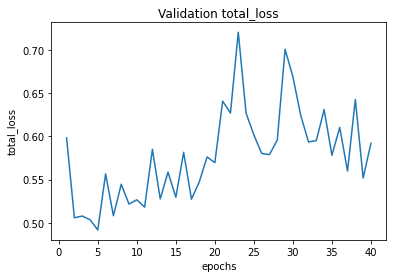

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Epochs,val_tot_loss)
plt.xlabel('epochs')
plt.ylabel('total_loss')
plt.title('Validation total_loss')

Text(0.5, 1.0, 'Validation regressor loss')

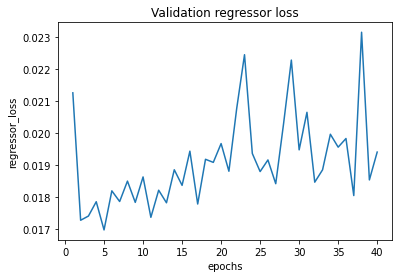

In [ ]:
plt.plot(Epochs,val_reg_loss)
plt.xlabel('epochs')
plt.ylabel('regressor_loss')
plt.title('Validation regressor loss')

Text(0.5, 1.0, 'Validation classifier loss')

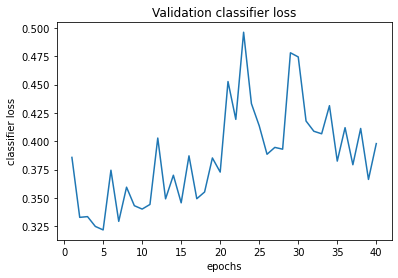

In [ ]:
plt.plot(Epochs,val_class_loss)
plt.xlabel('epochs')
plt.ylabel('classifier loss')
plt.title('Validation classifier loss')

### POST PROCESSING

In [ ]:
boxhead = BoxHead()
boxhead = boxhead.to(device)## initilize device to cpu or cuda

learning_rate = 10e-5

optimizer=torch.optim.Adam(boxhead.parameters(),lr=learning_rate,weight_decay=0.0001)
path='/content/drive/MyDrive/FasterRCNN/Modelslamb10/boxhead/boxhead_epoch10'
checkpoint = torch.load(path)
boxhead.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']

In [ ]:
test_batch_size = 1
test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

### Image plots that contain the top 20 boxes produced by the Box Head for some images of the test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

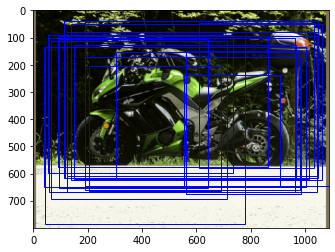

In [ ]:
e=0
with torch.no_grad():
  rpn.eval()
  boxhead.eval()
  for iter,data in enumerate(test_loader):
    img,_,_,_,index = [data[i] for i in range(len(data))]
    index = torch.tensor(index).view(-1)
    target_class = proposal_class[index].view(-1,1).to(device)
    target_bbox = proposal_gt_bboxes_p[index].view(-1,4).to(device)
    img = torch.cat(img).float().to(device)
    backout = backbone(img)
    fpn_feat_list = list(backout.values())
    im_lis = ImageList(img,[(800,1088)]*img.shape[0])
    rpnout = rpn(im_lis,backout)
    proposals = [proposal[:200,:] for proposal in rpnout[0]]
    feat_vectors = ROIAlign(fpn_feat_list,proposals)
    feat_vectors = torch.cat(feat_vectors)
    class_out,reg_out = boxhead(feat_vectors)

    if e==0:
      break
plt.figure()
bbox_color=['b','g','r']
fig,ax = plt.subplots(1)
opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
img_plot = opp_transform(img[0].squeeze(0))
img_plot=img_plot*255.0
plt.imshow(img_plot.cpu().numpy().transpose((1,2,0)).astype('long'))
m=nn.Softmax(dim=1)
new_class=m(class_out)
temp_out_obj,inds=torch.max(new_class,dim=1)

maximum=0
for i in range(len(temp_out_obj)):
  if inds[i]==0:
    temp_out_obj[i]=0
  if temp_out_obj[i]<0.5:
    temp_out_obj[i]=0 
for k in range(20):
  maximum=torch.max(temp_out_obj)
  count=0   
  for i in range(200):
      if (temp_out_obj[i]==maximum):
        count+=1
   
        x_c=(reg_out[i][0])*(proposals[0][i][2]-proposals[0][i][0])+(proposals[0][i][0]+proposals[0][i][2])/2
        y_c=(reg_out[i][1])*(proposals[0][i][3]-proposals[0][i][1])+(proposals[0][i][1]+proposals[0][i][3])/2
        w=torch.exp(reg_out[i][2])*(proposals[0][i][2]-proposals[0][i][0])
        h=torch.exp(reg_out[i][3])*(proposals[0][i][3]-proposals[0][i][1])
    
        x1=x_c-w/2
        y1=y_c-h/2
     
        rect1 = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor=bbox_color[inds[i]-1],facecolor='none')
        ax.add_patch(rect1)  
        temp_out_obj[i]=torch.min(temp_out_obj)
      if (count==20):
        break
plt.show()

### 5. Image plots of the regressed boxes after the postprocessing

### PRE-NMS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

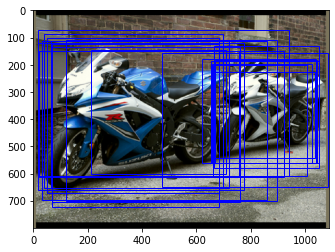

In [ ]:
e=0
with torch.no_grad():
  rpn.eval()
  boxhead.eval()
  for iter,data in enumerate(test_loader):
    img,_,_,_,index = [data[i] for i in range(len(data))]
    index = torch.tensor(index).view(-1)
    target_class = proposal_class[index].view(-1,1).to(device)
    target_bbox = proposal_gt_bboxes_p[index].view(-1,4).to(device)
    img = torch.cat(img).float().to(device)
    backout = backbone(img)
    fpn_feat_list = list(backout.values())
    im_lis = ImageList(img,[(800,1088)]*img.shape[0])
    rpnout = rpn(im_lis,backout)
    proposals = [proposal[:200,:] for proposal in rpnout[0]]
    feat_vectors = ROIAlign(fpn_feat_list,proposals)
    feat_vectors = torch.cat(feat_vectors)
    class_out,reg_out = boxhead(feat_vectors)

    if e==0:
      break
plt.figure()
bbox_color=['b','g','r']
fig,ax = plt.subplots(1)
opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
img_plot = opp_transform(img[0].squeeze(0))
img_plot=img_plot*255.0
plt.imshow(img_plot.cpu().numpy().transpose((1,2,0)).astype('long'))
m=nn.Softmax(dim=1)
new_class=m(class_out)
temp_out_obj,inds=torch.max(new_class,dim=1)

maximum=0
for i in range(len(temp_out_obj)):
  if inds[i]==0:
    temp_out_obj[i]=0
  if temp_out_obj[i]<0.5:
    temp_out_obj[i]=0 
for k in range(20):
  maximum=torch.max(temp_out_obj)
  count=0   
  for i in range(200):
      if (temp_out_obj[i]==maximum):
        count+=1

        x_c=(reg_out[i][0])*(proposals[0][i][2]-proposals[0][i][0])+(proposals[0][i][0]+proposals[0][i][2])/2
        y_c=(reg_out[i][1])*(proposals[0][i][3]-proposals[0][i][1])+(proposals[0][i][1]+proposals[0][i][3])/2
        w=torch.exp(reg_out[i][2])*(proposals[0][i][2]-proposals[0][i][0])
        h=torch.exp(reg_out[i][3])*(proposals[0][i][3]-proposals[0][i][1])

        x1=x_c-w/2
        y1=y_c-h/2

        rect1 = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor=bbox_color[inds[i]-1],facecolor='none')
        ax.add_patch(rect1)  
        temp_out_obj[i]=torch.min(temp_out_obj)
      if (count==20):
        break
plt.show()

### POST-NMS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

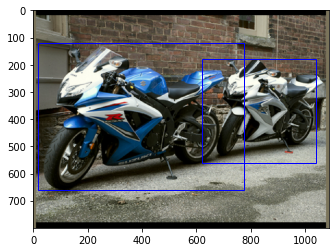

In [ ]:
m=nn.Softmax(dim=1)
new_class=m(class_out)
temp_out_obj,inds=torch.max(new_class,dim=1)
maximum=0
for i in range(len(temp_out_obj)):
  if inds[i]==0:
    temp_out_obj[i]=0
  if temp_out_obj[i]<0.5:
    temp_out_obj[i]=0

twenty= torch.zeros(20,4)
twenty_obj = torch.zeros(20,1)
twenty_ind=torch.zeros(20,1)
for k in range(20):
  maximum=torch.max(temp_out_obj)
  count=0   
  for i in range(200):
      if (temp_out_obj[i]==maximum):
        count+=1

        x_c=(reg_out[i][0])*(proposals[0][i][2]-proposals[0][i][0])+(proposals[0][i][0]+proposals[0][i][2])/2
        y_c=(reg_out[i][1])*(proposals[0][i][3]-proposals[0][i][1])+(proposals[0][i][1]+proposals[0][i][3])/2
        w=torch.exp(reg_out[i][2])*(proposals[0][i][2]-proposals[0][i][0])
        h=torch.exp(reg_out[i][3])*(proposals[0][i][3]-proposals[0][i][1])
        # print(x_c,y_c,w,h,x1,y1)
        x1=x_c-w/2
        y1=y_c-h/2
        x2=x_c+w/2
        y2=y_c+h/2
        # print(x1,y1)
        twenty[k][0]=x1
        twenty[k][1]=y1
        twenty[k][2]=x2
        twenty[k][3]=y2
        twenty_obj[k]=temp_out_obj[i]
        twenty_ind[k]=inds[i]
        temp_out_obj[i]=torch.min(temp_out_obj)
      if (count==20):
        break

for i in range(20):
    if twenty_ind[i]==1:
      bb1= twenty[i]
      for j in range(20):
        if twenty_ind[j]==1:
          bb2=twenty[j]
          if (i!=j):
            iou= IOU (bb1, bb2)
            if iou > 0.5:
              if twenty_obj[i]>twenty_obj[j]:
                twenty_obj[j]=0
              elif twenty_obj[i]<twenty_obj[j]:
                twenty_obj[i]=0
for i in range(20):
    if twenty_ind[i]==2:
      bb1= twenty[i]
      for j in range(20):
        if twenty_ind[j]==2:
          bb2=twenty[j]
          if (i!=j):
            iou= IOU (bb1, bb2)
            if iou > 0.5:
              if twenty_obj[i]>twenty_obj[j]:
                twenty_obj[j]=0
              elif twenty_obj[i]<twenty_obj[j]:
                twenty_obj[i]=0
for i in range(20):
    if twenty_ind[i]==3:
      bb1= twenty[i]
      for j in range(20):
        if twenty_ind[j]==3:
          bb2=twenty[j]
          if (i!=j):
            iou= IOU (bb1, bb2)
            if iou > 0.5:
              if twenty_obj[i]>twenty_obj[j]:
                twenty_obj[j]=0
              elif twenty_obj[i]<twenty_obj[j]:
                twenty_obj[i]=0
plt.figure()
fig,ax = plt.subplots(1)

plt.imshow(img_plot.cpu().numpy().transpose((1,2,0)).astype('long'))
iter1=0
iter2=0
iter3=0

for i in range(20):
  if twenty_obj[i]>0 and twenty_ind[i]==1:
    iter1+=1
    rect1 = patches.Rectangle((twenty[i][0],twenty[i][1]),(twenty[i][2]-twenty[i][0]),(twenty[i][3]-twenty[i][1]),linewidth=1,edgecolor=bbox_color[int(twenty_ind[i]-1)],facecolor='none')
    ax.add_patch(rect1)
 
    if iter1==2:
      break
for i in range(20):
  if twenty_obj[i]>0 and twenty_ind[i]==2:
    iter2+=1
    rect1 = patches.Rectangle((twenty[i][0],twenty[i][1]),(twenty[i][2]-twenty[i][0]),(twenty[i][3]-twenty[i][1]),linewidth=1,edgecolor=bbox_color[int(twenty_ind[i]-1)],facecolor='none')
    ax.add_patch(rect1)
    if iter2==2:
      break
for i in range(20):
  if twenty_obj[i]>0 and twenty_ind[i]==3:
    iter3+=1
    rect1 = patches.Rectangle((twenty[i][0],twenty[i][1]),(twenty[i][2]-twenty[i][0]),(twenty[i][3]-twenty[i][1]),linewidth=1,edgecolor=bbox_color[int(twenty_ind[i]-1)],facecolor='none')
    ax.add_patch(rect1)
    if iter3==2:
      break


plt.show()

### mAP, AP and Precision Recall Curves

In [ ]:
def nms(class_out,reg_out,proposals):
  a=torch.zeros(2)
  b=torch.zeros(2)
  c=torch.zeros(2)
  d=torch.zeros(2)
  e=torch.zeros(2)
  f=torch.zeros(2)
  x=torch.zeros(2)
  y=torch.zeros(2)
  z=torch.zeros(2)
  m=nn.Softmax(dim=1)
  new_class=m(class_out)
  temp_out_obj,inds=torch.max(new_class,dim=1)
  maximum=0
  for i in range(len(temp_out_obj)):
    if inds[i]==0:
      temp_out_obj[i]=0
    if temp_out_obj[i]<0.5:
      temp_out_obj[i]=0

  twenty= torch.zeros(20,4)
  twenty_obj = torch.zeros(20,1)
  twenty_ind=torch.zeros(20,1)
  for k in range(20):
    maximum=torch.max(temp_out_obj)
    count=0   
    for i in range(200):
        if (temp_out_obj[i]==maximum):
          count+=1

          x_c=(reg_out[i][0])*(proposals[0][i][2]-proposals[0][i][0])+(proposals[0][i][0]+proposals[0][i][2])/2
          y_c=(reg_out[i][1])*(proposals[0][i][3]-proposals[0][i][1])+(proposals[0][i][1]+proposals[0][i][3])/2
          w=torch.exp(reg_out[i][2])*(proposals[0][i][2]-proposals[0][i][0])
          h=torch.exp(reg_out[i][3])*(proposals[0][i][3]-proposals[0][i][1])

          x1=x_c-w/2
          y1=y_c-h/2
          x2=x_c+w/2
          y2=y_c+h/2
          
          twenty[k][0]=x1
          twenty[k][1]=y1
          twenty[k][2]=x2
          twenty[k][3]=y2
          twenty_obj[k]=temp_out_obj[i]
          twenty_ind[k]=inds[i]
          temp_out_obj[i]=torch.min(temp_out_obj)
        if (count==20):
          break

  for i in range(20):
      if twenty_ind[i]==1:
        bb1= twenty[i]
        for j in range(20):
          if twenty_ind[j]==1:
            
            bb2=twenty[j]

            if (i!=j):
              iou= IOU (bb1, bb2)
              if iou > 0.5:
                if twenty_obj[i]>twenty_obj[j]:
                  twenty_obj[j]=0
                elif twenty_obj[i]<twenty_obj[j]:
                  twenty_obj[i]=0
  for i in range(20):
      if twenty_ind[i]==2:
        bb1= twenty[i]
        for j in range(20):
          if twenty_ind[j]==2:
            bb2=twenty[j]
            if (i!=j):
              iou= IOU (bb1, bb2)
              if iou > 0.5:
                if twenty_obj[i]>twenty_obj[j]:
                  twenty_obj[j]=0
                elif twenty_obj[i]<twenty_obj[j]:
                  twenty_obj[i]=0
  for i in range(20):
      if twenty_ind[i]==3:
        bb1= twenty[i]
        for j in range(20):
          if twenty_ind[j]==3:
            bb2=twenty[j]
            if (i!=j):
              iou= IOU (bb1, bb2)
              if iou > 0.5:
                if twenty_obj[i]>twenty_obj[j]:
                  twenty_obj[j]=0
                elif twenty_obj[i]<twenty_obj[j]:
                  twenty_obj[i]=0
  cnt=0
  for i in range(20):
    if twenty_obj[i]>0 and twenty_ind[i]==1:
      a[cnt]=twenty_ind[i]
      b[cnt]=i
      x[cnt]=twenty_obj[i]
      cnt+=1
    if cnt==2:
      break
  cnt=0
  for i in range(20):
    if twenty_obj[i]>0 and twenty_ind[i]==2:
      c[cnt]=twenty_ind[i]
      d[cnt]=i
      y[cnt]=twenty_obj[i]
      cnt+=1
    if cnt==2:
      break
  cnt=0
  for i in range(20):
    if twenty_obj[i]>0 and twenty_ind[i]==3:
      e[cnt]=twenty_ind[i]
      f[cnt]=i
      z[cnt]=twenty_obj[i]
      cnt+=1
    if cnt==2:
      break
  return a,b,c,d,e,f,x,y,z,twenty

In [ ]:
def evaluation(a,b,c,d,e,f,x,y,z,twenty,labels,bbox):
  
  # print(x)
  classes=np.concatenate((a, c, e), axis=None)
  indexes=np.concatenate((b, d, f), axis=None)
  scores=np.concatenate((x, y, z), axis=None)
  true_1=0
  true_2=0
  true_3=0
  bbox_1=0
  bbox_2=np.zeros(4)
  count=np.zeros(6)

  
  for i in range(len(labels[0])):
    if len(bbox[0])==2:
      bbox_2=bbox[0][i]
    else:
      bbox_2=bbox[0]
    cnt1=0
    cnt2=0
    cnt3=0
    nnt1=0
    nnt2=0
    nnt3=0
    for j in range(len(classes)):
      bbox_1=twenty[int(indexes[j])]
      if (label[0][i]==classes[j] and IOU(bbox_1, bbox_2)>0.5):
        if classes[j]==1 and cnt1==0:
          match_1.append(1)
          score_1.append(scores[j])
          cnt1=1
        elif classes[j]==2 and cnt2==0:
          match_2.append(1)
          score_2.append(scores[j])
          cnt2=1
        elif classes[j]==3 and cnt3==0:
          match_3.append(1)
          score_3.append(scores[j])
          cnt3=1
      elif (classes[j]==label[0][i] and IOU(bbox_1 ,bbox_2)<0.5):   
        if classes[j]==1 and nnt1==0 and cnt1==0:
          match_1.append(0)
          score_1.append(scores[j])
          nnt1=1
        elif classes[j]==2 and nnt2==0 and cnt2==0:
          match_2.append(0)
          score_2.append(scores[j])
          nnt2=1
        elif classes[j]==3 and nnt3==0 and cnt3==0:
          match_3.append(0)
          score_3.append(scores[j])
          nnt3=1
    if (label[0][i]==1):
      true_1+=1
    elif (label[0][i]==2):
      true_2+=1
    elif (label[0][i]==3): 
      true_3+=1  

        
            
  return match_1, match_2, match_3,score_1,score_2,score_3,true_1,true_2,true_3

In [ ]:
total_trues_1=0
total_trues_2=0
total_trues_3=0
match_1=[]
match_2=[]
match_3=[]
score_1=[]
score_2=[]
score_3=[]
true_1=0
true_2=0
true_3=0

with torch.no_grad():
  rpn.eval()
  boxhead.eval()
  for iter,data in enumerate(test_loader):
    img,label,_,bbox,index = [data[i] for i in range(len(data))]
    index = torch.tensor(index).view(-1)
    img = torch.cat(img).float().to(device)
    backout = backbone(img)
    fpn_feat_list = list(backout.values())
    im_lis = ImageList(img,[(800,1088)]*img.shape[0])
    rpnout = rpn(im_lis,backout)
    proposals = [proposal[:200,:] for proposal in rpnout[0]]
    feat_vectors = ROIAlign(fpn_feat_list,proposals)
    feat_vectors = torch.cat(feat_vectors)
    class_out,reg_out = boxhead(feat_vectors)
    a,b,c,d,e,f,x,y,z,twenty=nms(class_out,reg_out,proposals)

   
    match_1, match_2, match_3,score_1,score_2,score_3,true_1,true_2,true_3=evaluation(a,b,c,d,e,f,x,y,z,twenty,label,bbox)
    
    total_trues_1+=true_1
    total_trues_2+=true_2
    total_trues_3+=true_3
    
    print(iter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
from sklearn.metrics import auc
def average_precision(match, score, true):
  
  precisions=[]
  recalls=[]
  correct=0
  for i in range(len(match)):
    if match[i]:
      correct+=match[i]
      x=correct/(i+1)
      
      precisions.append(x)
      y=correct/true
      
      recalls.append(y)

  recall=np.asarray(precisions)
  precision=np.asarray(recalls)
  area=auc(recall,precision)
  return area,precision,recall

### mAP and AP

In [ ]:
cnt=0
AP=0
if len(match_1)>0:
  AP1,sorted_precision_1,sorted_recall_1=average_precision(match_1,score_1,total_trues_1)
  cnt+=1
if len(match_2)>0:
  AP2,sorted_precision_2,sorted_recall_2=average_precision(match_2,score_2,total_trues_2)
  cnt+=1
if len(match_3)>0:
  AP3,sorted_precision_3,sorted_recall_3=average_precision(match_3,score_3,total_trues_3)
  cnt+=1
if cnt>0:
  mAp = (AP1+AP2+AP3)/cnt
  print(mAp)
  print(AP1,AP2,AP3)

0.5545985643181636
0.77372432245172 0.34881963351608297 0.5412517369866876


### PR CURVES

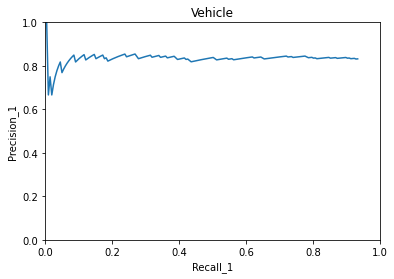

In [ ]:
import matplotlib.pyplot as plt
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(sorted_recall_1,sorted_precision_1)
plt.title('Vehicle')
plt.ylabel('Precision_1')
plt.xlabel('Recall_1')

plt.show()

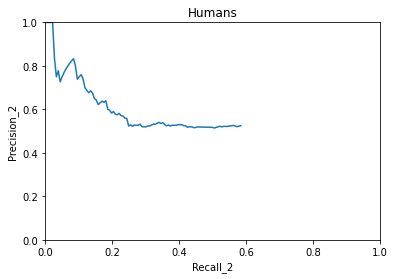

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sorted_recall_2,sorted_precision_2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Humans')
plt.ylabel('Precision_2')
plt.xlabel('Recall_2')
plt.show()

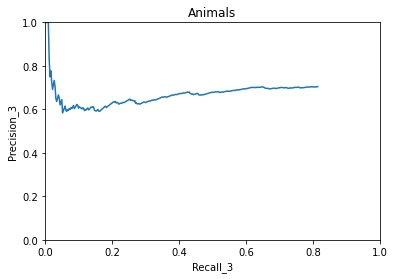

In [ ]:
import matplotlib.pyplot as plt
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(sorted_recall_3,sorted_precision_3)
plt.title('Animals')

plt.ylabel('Precision_3')
plt.xlabel('Recall_3')


plt.show()